# Exercise Sheet 4

## 1 The Message Passing Framework

### 1. Random Graph Neural Networks
Consider the ogbn-arxiv graph. Implement a Basic GNN (slide 8) using your message passing framework code from the previous exercise sheet. Ignore the training by backpropagation, for now, by proceeding as follows:

Initialize $r_0(v)$ = v[′attr′] by using the 128-dimensional attribute vectors.

For k ∈ {0,1,2,3} create random matrices $W^{self}_k ,W^{neigh}_k ∈ [−1,1]^{d_k×d_{k+1}}$ and
random bias vectors $b_k ∈[−1,1]^{d_{k+1}}$. Choose the dimensionalities $d_k$, resp. $d_{k+1}$,
appropriately.

Use a nonlinearity function σ of your choice.

For each k ∈{0,1,2,3}, perform a node classification based on vertex representations
$r_k$ using a simple logistic regression classifier w.r.t. the target attribute label. Plot the
accuracy scores over k.

In [31]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import timeit
import math as m

def update_fn(wself, wneigh, bias, self_rep, neigh_rep):
    return np.tanh(np.einsum('ij,bj->bi', wself.T, self_rep)
                   + np.einsum('ij,bj->bi', wneigh.T, neigh_rep)
                   + bias)
    
def aggregation_fn(array):
    return np.sum(array, axis=0)

def msg_passing(wself, wneigh, bias, g, feat_reps, n_runs, agg, upd): #note that we need to change this if we want to input only a subgraph
    current_reps = np.copy(feat_reps)
    neighbors = g.get_adjlist(mode='all')
    
    results = []
    for run in range(n_runs):
        print("run", run)
        aggregates = []
        for idx in range(current_reps.shape[0]):
            # fetch the attributes out of the current representation array
            neigh_attr = np.take(current_reps, neighbors[idx], axis=0)
            # aggregate the attributes of the neighbors
            aggregates.append(agg(neigh_attr))
            
        aggregates = np.stack(aggregates, axis=0)
        # update the current representation
        update = upd(wself[run], wneigh[run], bias[run], current_reps, aggregates)
        
        results.append(update)
        current_reps = np.copy(update)

    return results

In [32]:
# read graph and initialize r0 as v['attr']
g = ig.Graph.Read_Pickle('ogbn-arxiv.pickle').as_undirected()
init_feature_rep = np.array([v['attr'] for v in g.vs()])

(169343, 128)


In [38]:
# create matrices (per k)and bias 

k_list = np.array([0, 1, 2, 3])
dk = [128, 128, 128, 128, 128] # dimension of feature can change in each iteration

np.random.seed(seed=3)

wself = [2 * np.random.random_sample((dk[k], dk[k+1])) - 1 for k in k_list]
wneigh = [2 * np.random.random_sample((dk[k], dk[k+1])) - 1 for k in k_list]
bias = [2 * np.random.random_sample((dk[k+1])) - 1 for k in k_list]

In [39]:
runs = len(k_list)
t1 = timeit.default_timer()
result = msg_passing(wself, wneigh, bias, g, init_feature_rep, runs, aggregation_fn, update_fn)
rtime = timeit.default_timer() - t1
print("Run time:", rtime,"s")

run 0
run 1
run 2
run 3
Run time: 42.04491879000125 s


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=3, max_iter=100, solver='saga')
t1 = timeit.default_timer()
score = []
y = np.array(g.vs['label'])

for k in k_list:
    x_train, x_test, y_train, y_test = train_test_split(result[k], y, test_size=0.33, random_state=42)
    lr.fit(x_train, y_train.ravel())
    score.append(lr.score(x_test, y_test))
    
train_time = timeit.default_timer() - t1
print("Train time:", train_time,"s")

k: [0 1 2 3]
Accuracy: [0.5530742251807315, 0.5599992842316226, 0.5507658721637678, 0.5515174289599886]


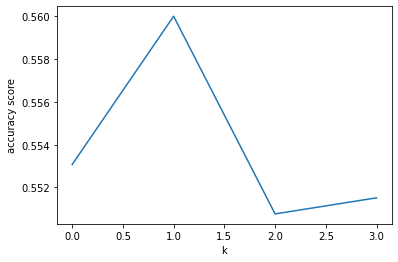

In [42]:
print("k:", k_list)
print("Accuracy:", score)
plt.figure()
plt.plot(k_list, score)
plt.xlabel("k")
plt.ylabel("accuracy score")
plt.show()


## 2 Degree Normalization

Once again consider the ogbn-arxiv graph. Implement two Basic GNNs A,B (slide 8) using your message passing framework code from the previous exercise sheet. Ignore the training by backpropagation, for now, by proceeding as follows:

•Initialize r0(v) = 1 ∈R100, i.e., to the 100-dimensional vector of ones.

•For k ∈ {0,1,2,3} create random matrices $W^{self}_k ,W^{neigh}_k ∈ [−1,1]^{100×100}$ and
random bias vectors $b_k ∈[−1,1]^{100}$.

•Use a nonlinearity function σ of your choice.

•For GNN A use the sum aggregator (i.e., don’t change the formula on slide 8).

•For GNN B, use the mean aggregator, i.e., set $r_{k+1}(v) = σ(W^{self}_k*r_k(v) + W^{neigh}_k*\frac{1}{|N(v)|}*\sum_{w\in N(v)}r_k(w)+b_k)$

For each k ∈{0,1,2,3}, perform a node regression task based on vertex representations
$r_k$ using a simple linear regression. This time choose the node degrees as target labels.
Plot the accuracy scores over k. What do you observe?

In [ ]:
num_vertices = g.vcount()
init_feature_rep = np.ones([num_vertices,100])
#create matrices (per k)and bias 
k = np.array([0,1,2,3])
dk = 100

np.random.seed(seed=3)
wself = np.array((2*np.random.random_sample((len(k),dk,dk))-1)) #interval [-1,1) - better way to do it??
wneigh = np.array((2*np.random.random_sample((len(k),dk,dk))-1)) #interval [-1,1)
bias = np.array((2*np.random.random_sample((len(k),dk))-1)) #interval [-1,1)

#define different aggregation functions
def agg1(array):
    return np.sum(array,axis=0)
def agg2(array):
    return np.mean(array,axis=0)

In [ ]:
runs=len(k)
t1 = timeit.default_timer()
print("Run 'sum' version")
result_aggSum = np.asarray(msg_passing_flexagg(wself,wneigh,bias,g,init_feature_rep,runs,agg1))
print("Run 'mean' version")
result_aggMean = np.asarray(msg_passing_flexagg(wself,wneigh,bias,g,init_feature_rep,runs,agg2))
rtime = timeit.default_timer() - t1
print("Run time:", rtime,"s")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn.metrics import accuracy_score

lr = LinearRegression()
t1 = timeit.default_timer()
score = np.empty([2,len(k)],dtype=float)
y = np.array(g.degree(g.vs(),mode='all')) #get the degree of all nodes as test values

#sum aggregation
for idx,k_value in enumerate(k):
    #x_train, x_test, y_train, y_test = train_test_split(, y, test_size=0.2, random_state=42)
    #lr.fit(x_train,y_train.ravel())
    #score[0,idx] = lr.score(x_test,y_test)
    scores = cross_val_score(LinearRegression(), result_aggSum[k_value], y, cv=5, scoring='r2')
    score[0,idx] = scores.mean()
#mean aggregation
for idx,k_value in enumerate(k):
    #x_train, x_test, y_train, y_test = train_test_split(result_aggMean[k_value], y, test_size=0.2, random_state=42)
    #lr.fit(x_train,y_train.ravel())
    #score[1,idx] = lr.score(x_test,y_test)
    scores = cross_val_score(LinearRegression(), result_aggMean[k_value], y, cv=5, scoring='r2')
    score[1,idx] = scores.mean()
    
train_time = timeit.default_timer() - t1
print(score)
print("Train time:", train_time,"s")

In [ ]:
print("k:",k)
print("Accuracy:", score)
plt.figure()
plt.scatter(k,score[0,:],color='red',label='sum aggregator',marker="+")
plt.scatter(k,score[1,:],color='blue',label='mean aggregator',marker="4")
plt.legend(loc="lower left")
plt.xlabel("k")
plt.ylabel("accuracy score")
plt.title("both combined")
plt.show()

plt.figure()
plt.scatter(k,score[0,:],color='red',label='sum aggregator',marker="+")
#plt.scatter(k,score[1,:],color='blue',label='mean aggregator',marker="4")
plt.legend(loc="center left")
plt.xlabel("k")
plt.ylabel("accuracy score")
plt.title("only sum aggregator")
plt.show()

plt.figure()
#plt.scatter(k,score[0,:],color='red',label='sum aggregator',marker="+")
plt.scatter(k,score[1,:],color='blue',label='mean aggregator',marker="4")
plt.legend(loc="center left")
plt.xlabel("k")
plt.ylabel("accuracy score")
plt.title("only mean aggregator")
plt.show()

## 3 PyTorch Geometric

PyTorch Geometric or PYG is a framework for graph neural networks on top of PyTorch.
It already implements GINs, GCNs and quite a lot of other GNN variants.
Implement the neural network architecture presented on slide 24 for both GINs and GCNs using PYG for the node classification task on the cora graph. You may follow the tutorial of PYG that conveniently shows how to implement a GCN layer for this graph.
Implement three GIN, resp. GCN, layers and add a fully connected layer to transform your representations r3 to the expected input of the softmax function.
Split your test data into 30% validation and 70% test. Evaluate the accuracy of your model after each epoch on the validation data and plot the accuracy over epochs.